<center><u><h1>NLP Project Sentiment Analysis Recommender System </center></u></h1>


![](https://freelancedatascientist.net/wp-content/uploads/2020/05/carrot2-1024x679.png)


Goals:
Suggest top five products for the investment bracket, with detailed report sentiment analysis on those products reviews.



In [109]:
#import the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Step1: Importing Required packages and loading required dataset

In [110]:
#import pandas
import pandas as pd
#import numpy
import numpy as np
#NearestNeighbors from sklearn
from sklearn.neighbors import NearestNeighbors
#import logistic regression
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import *
from sklearn.metrics import *
#import SelectKBest from sklearn
from sklearn.feature_selection import SelectKBest
#import TfidfTransformer, TfidfVectorizer from sklearn
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
#import re
import re
#import WordCloud, STOPWORDS, ImageColorGenerator from word cloud
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
#import train_test_split from sklearn
from sklearn.model_selection import train_test_split
#import neighbors
from sklearn import neighbors
#import matplotlib
import matplotlib.pyplot as plt
#% matplotlib inline
%matplotlib inline

I have used 5-core Home and Kitchen reviews dataset. It is subset of the data in which all users and items have at least 5 reviews.


Download the dataset from here:
https://drive.google.com/file/d/1eqiOjn3s6IwoXLaLjhr8a1c28PbCV_0M/view?usp=sharing



Refer:
https://docs.python.org/3/library/gzip.html

In [111]:
#import gzip
import gzip

#def parse as function and path as input parameter
def parse(path):
  #open the path with gzip
   g=gzip.open(path,'rb')
  #iterate in for loop
   for l in g:
    #yield eval(l)
     yield eval(l)

#define a function and pass path as parameter
def getDF(path):
  #i=0
   i=0
  #df = {}
   df={}
  #iterate over for loop
  #for d in parse(path):
   for d in parse(path):
    #df[i]=d
     df[i]=d
    #i += 1
     i=i+1
  #return pd.DataFrame.from_dict(df, orient='index')
   return pd.DataFrame.from_dict(df,orient='index')

#pass the dataset that is present in the drive
df=getDF('/content/drive/MyDrive/Colab Notebooks/Deep learning/DL projects/reviews_Home_and_Kitchen_5.json.gz')

I would like to see the top five rows of dataset.

In [112]:
#partial top 5 views
df.head(5).T

,0,1,2,3,4
reviewerID,APYOBQE6M18AA,A1JVQTAGHYOL7F,A3UPYGJKZ0XTU4,A2MHCTX43MIMDZ,AHAI85T5C2DH3
asin,0615391206,0615391206,0615391206,0615391206,0615391206
reviewerName,Martin Schwartz,Michelle Dinh,mirasreviews,"M. Johnson ""Tea Lover""",PugLover
helpful,"[0, 0]","[0, 0]","[26, 27]","[14, 18]","[0, 0]"
reviewText,My daughter wanted this book and the price on ...,I bought this zoku quick pop for my daughterr ...,There is no shortage of pop recipes available ...,This book is a must have if you get a Zoku (wh...,This cookbook is great. I have really enjoyed...
overall,5.0,5.0,4.0,5.0,4.0
summary,Best Price,zoku,"Excels at Sweet Dessert Pops, but Falls Short ...",Creative Combos,A must own if you own the Zoku maker...
unixReviewTime,1382140800,1403049600,1367712000,1312416000,1402099200
reviewTime,"10 19, 2013","06 18, 2014","05 5, 2013","08 4, 2011","06 7, 2014"


###Data Dict

The above dataset has 9 variables. Those are

reviewerID: ID of the reviewer

asin: ID of the product  

reviewerName: Name of the reviewer

helpful: helpfulness rating of the reviewer, e.g: 2/3

reviewText: text of the review

overall: rating of the product

summary: summary of the review

unixReviewTime: time of the review (unix time)

reviewTime: time of the review (raw)


In [113]:
#checking the shape of dataset
df.shape

(551682, 9)

From the above we can say that the dataset has 551682 rows and 9 columns of information.

#### Step2: Preparing data for KNN modeling

In [114]:
# Make new two columns out of 'helpful' column
df[['helpfulfirstelement','helpfulsecondelement']]=pd.DataFrame(df.helpful.values.tolist(),index=df.index)

In [115]:
#drop the helpful with axis=1
df.drop('helpful',axis=1,inplace=True)

In [116]:
#checking the shape
df.shape

(551682, 10)

I take the prodcuts with more than 100 product reviews for further analysis and modeling.

In [117]:
#reviews_count = df.groupby('asin').count().reset_index()
reviews_count=df.groupby('asin').count().reset_index()

In [118]:
#checking the partial top view
reviews_count.head().T

,0,1,2,3,4
asin,0615391206,0689027818,0912696591,1223070743,1567120709
reviewerID,11,5,93,8,16
reviewerName,11,5,93,8,16
reviewText,11,5,93,8,16
overall,11,5,93,8,16
summary,11,5,93,8,16
unixReviewTime,11,5,93,8,16
reviewTime,11,5,93,8,16
helpfulfirstelement,11,5,93,8,16
helpfulsecondelement,11,5,93,8,16


In [119]:
# merge the column of df and reviews_count, on = 'asin', how = 'right'
df_merged=pd.merge(df,reviews_count,on='asin',how='right')

In [120]:
df_merged.head().T

,0,1,2,3,4
reviewerID_x,APYOBQE6M18AA,A1JVQTAGHYOL7F,A3UPYGJKZ0XTU4,A2MHCTX43MIMDZ,AHAI85T5C2DH3
asin,0615391206,0615391206,0615391206,0615391206,0615391206
reviewerName_x,Martin Schwartz,Michelle Dinh,mirasreviews,"M. Johnson ""Tea Lover""",PugLover
reviewText_x,My daughter wanted this book and the price on ...,I bought this zoku quick pop for my daughterr ...,There is no shortage of pop recipes available ...,This book is a must have if you get a Zoku (wh...,This cookbook is great. I have really enjoyed...
overall_x,5.0,5.0,4.0,5.0,4.0
summary_x,Best Price,zoku,"Excels at Sweet Dessert Pops, but Falls Short ...",Creative Combos,A must own if you own the Zoku maker...
unixReviewTime_x,1382140800,1403049600,1367712000,1312416000,1402099200
reviewTime_x,"10 19, 2013","06 18, 2014","05 5, 2013","08 4, 2011","06 7, 2014"
helpfulfirstelement_x,0,0,26,14,0
helpfulsecondelement_x,0,0,27,18,0


In [121]:
#renaming the columns
df_merged.rename(columns={'reviewerID_y':'reviews_count','overall_x':'overall_review','summary_x':'summary_review'},inplace=True)

In [122]:
#merge the final columns
df_final = df_merged[['asin', 'summary_review', 'overall_review', 'reviews_count']]

In [123]:
df_final.head()
print(df_final.shape)

(551682, 4)


In [124]:
#The code will sort the reviews by the number of reviews, and then return a list of all reviews with the highest count.
df_merged=df_merged.sort_values(by='reviews_count',ascending=False)

In [125]:
# selecting products with more than 50 reviews
df_count=df_merged[df_merged.reviews_count>50]

In [126]:
#The code will return a pandas DataFrame with the mean rating for each asin.
df_review_mean=df.groupby('asin').mean().reset_index()

<ipython-input-126-e9df2c54e3ee>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_review_mean=df.groupby('asin').mean().reset_index()


In [127]:
#checking the partial view of dataset
df_review_mean.head(5)

,asin,overall,unixReviewTime,helpfulfirstelement,helpfulsecondelement
0,0615391206,4.454545,1.364429e+09,8.181818,9.363636
1,0689027818,5.000000,1.216253e+09,3.600000,3.800000
2,0912696591,4.548387,1.346279e+09,1.688172,1.817204
3,1223070743,4.250000,1.375024e+09,0.000000,0.000000
4,1567120709,4.062500,1.324523e+09,2.250000,2.562500


In [128]:
#The code attempts to create a DataFrame of all the reviews for each product.
df_summary_review=pd.DataFrame(df_count.groupby('asin')['summary_review'].apply(list).reset_index())

In [129]:
#merge the reviews
#df_model = pd.merge(df_summary_review, df_review_mean, on = 'asin', how = 'inner')
df_model=pd.merge(df_summary_review,df_review_mean,on='asin',how='inner')

In [130]:
#df_model_data = df_model[['asin', 'summary_review', 'overall']]
df_model_data=df_model[['asin','summary_review','overall']]

In [131]:
#checking the partial view
df_model_data.head(5)

,asin,summary_review,overall
0,0912696591,"[Good refresher, great book for beginners, Nee...",4.548387
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ...",3.948052
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,...",4.473934
3,B00002N5Z9,"[Too big, loud, powerful, lets bugs through fo...",4.176471
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ...",4.563107


##### Text processing for modeling:

In [132]:
#define a text process as text as input parameter
def text_process(text):
    #make text lower
    text=text.lower()
    #text = re.sub('[^a-z]+', ' ', text).strip()
    text=re.sub('[^a-z]+', ' ', text).strip()
    #return text
    return text

The code will create a new column in the dataframe called clean_summary_review that is a string of all the text in df_model_data['summary_review'] with any single word or sentence replaced by an underscore.

In [133]:
#df_model_data['clean_summary_review'] = df_model_data['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)
df_model_data['clean_summary_review'] = df_model_data['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)

<ipython-input-133-7049a4e03145>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_data['clean_summary_review'] = df_model_data['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)


In [134]:
#checking the partial view
df_model_data['clean_summary_review'].head(5)

0    good refresher great book for beginners needed...
1    mighty mouse always have been happy with it wa...
2    cute and easy paddle broke within months omg t...
3    too big loud powerful lets bugs through for my...
4    my pot pressure cooker great product very good...
Name: clean_summary_review, dtype: object

In [135]:
#The code will drop all duplicates of the overall category.
df_model_data.drop_duplicates(['overall'],keep='last',inplace=True)

<ipython-input-135-0a6a7f3ebb7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_data.drop_duplicates(['overall'],keep='last',inplace=True)


In [136]:
#The code simply resets the index of the dataframe.
#df_model_data = df_model_data.reset_index()
df_model_data=df_model_data.reset_index()

#### TFIDF model feature extraction from clean_summary_review column:

In [137]:
#TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = 500)
tfidf=TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=500)
#The code will create a new dataframe with the tfidf values for each review.
x=tfidf.fit_transform(df_model_data['clean_summary_review'])

Splitting X into train and test datasets.

In [138]:
#The code creates a DataFrame with the data that is stored in X_reviews.
X_reviews=pd.DataFrame(x.A,columns=tfidf.get_feature_names_out()).astype(int)

In [139]:
#The code will create a list of reviews and then convert it into an array.
x_reviews_array=np.array(X_reviews)

In [140]:
#split_percent = 0.8
split_percent = 0.8
#The code is used to calculate the percentage of reviews that are positive and negative.
split_size=np.floor(split_percent*X_reviews.shape[0]).astype(int)

In [141]:
#split the dataset
#X_train = X_reviews_array[:split_size]
x_train=x_reviews_array[:split_size]
#X_test = X_reviews_array[split_size:]
x_test = x_reviews_array[split_size:]

#### Predictive Modeling: Let's use KNerighborsClassifier to classify: Predicting overall review based on product reviews:

Let's define the target variable for predictive modeling

The code starts by creating a list of the overall data.This is done with df_model_data['overall'].Then, it creates two variables: X_train and y_train.These are lists of all the training data for this model.The first variable, X_train, has shape[0] equal to 10 because there are 10 rows in that list.The second variable, y_test, has shape[0]: 9 because there are 9 columns in that list.Next, it creates an array called xy which contains all the features from both arrays (X and Y).

In [142]:
#y_train = df_model_data['overall'][:X_train.shape[0]].astype(int)
y_train = df_model_data['overall'][:x_train.shape[0]].astype(int)
#y_test = df_model_data['overall'][X_train.shape[0]:].astype(int)
y_test = df_model_data['overall'][x_train.shape[0]:].astype(int)

In [143]:
#knnclassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knnclassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
#The code creates a model that predicts the probability of an event occurring.
knnclassifier.fit(x_train,y_train)
#predict the results
knnclassifier_prediction=knnclassifier.predict(x_test)

In [144]:
#check the accucary score and mean squared error
print(accuracy_score(y_test,knnclassifier_prediction))
print(mean_squared_error(y_test,knnclassifier_prediction))

0.8949044585987261
0.10509554140127389


#### Word Clouding for each review group:

In [145]:
#he code will create a list of all the reviews for each overall rating.
review_text_for_overall=df.groupby('overall')['summary'].apply(list).reset_index()

In [146]:
#print top 5 view
review_text_for_overall

,overall,summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do..."
1,2.0,[Okay but you can figure it out yourself witho...
2,3.0,"[Good for what it's worth, Okay, Disappointed ..."
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short..."
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B..."


 The code starts by creating a list of review text objects.
 It then creates an empty string and appends the summary to it, which is done with the .join() method.
 The code then uses the text_process function to process each word in this string, which is done with the lambda x: text_process(x) function.
 The code takes the text of the review and converts it into a list of words, which are then joined together.

In [147]:
#review_text_for_overall['clean_summary'] = review_text_for_overall['summary'].apply(' '.join).apply(lambda x: text_process(x))
review_text_for_overall['clean_summary'] = review_text_for_overall['summary'].apply(' '.join).apply(lambda x: text_process(x))

In [148]:
#print top 5 view
review_text_for_overall

,overall,summary,clean_summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do...",waste of money sprelling only it doesn t do mu...
1,2.0,[Okay but you can figure it out yourself witho...,okay but you can figure it out yourself withou...
2,3.0,"[Good for what it's worth, Okay, Disappointed ...",good for what it s worth okay disappointed aga...
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short...",excels at sweet dessert pops but falls short o...
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B...",best price zoku creative combos love it beauti...


##### Write a function to draw wordcloud for each overall rating group:

In [149]:
#set the stop words #stop_words = set(STOPWORDS)
stop_words=set(STOPWORDS)
#define a function to plot wordcloud and txt_data as input parameter
def wordcloud_plot(txt_dat,title=None):
    #wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=300, max_font_size=30,scale=3, random_state=1).generate(str(txt_dat))
    wordcloud=WordCloud(background_color='white',stopwords=stop_words,max_words=300,max_font_size=30,
                        scale=3,random_state=1).generate(str(txt_dat))

    #plot the figure with figsize of 8,8
    fig=plt.figure(1,figsize=(8,8))
    plt.axis('off')
    #if title:
    if title:
        #fig.suptitle(title, fontsize=20)
         fig.suptitle(title,fontsize=20)
        #fig.subplots_adjust(top=2.3)
         fig.subplots_adjust(top=2.3)
    #plt with imshow w
    plt.imshow(wordcloud)
    #show the plt
    plt.show()

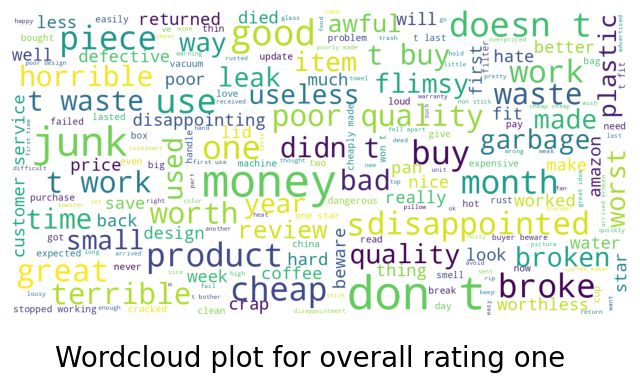

In [150]:
#plot the graph of one rating
#wordcloud_plot(review_text_for_overall['clean_summary'][0], title = 'Wordcloud plot for overall rating one')
wordcloud_plot(review_text_for_overall['clean_summary'][0], title = 'Wordcloud plot for overall rating one')

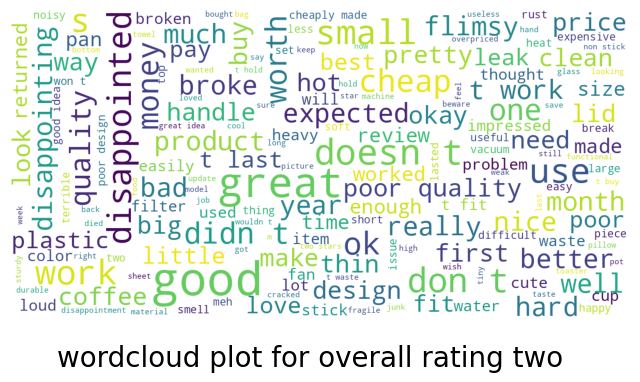

In [151]:
#plot the graph of two rating
wordcloud_plot(review_text_for_overall['clean_summary'][1],title='wordcloud plot for overall rating two')

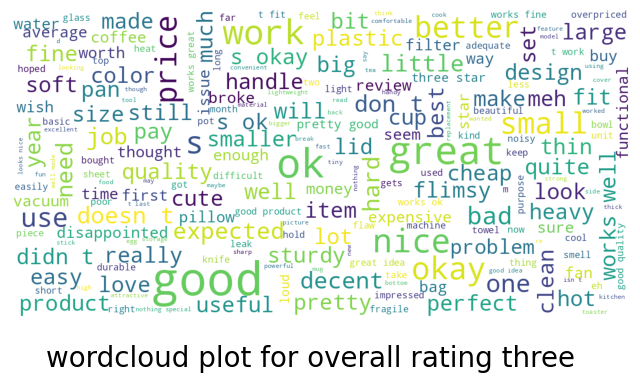

In [152]:
#plot the graph of three rating
wordcloud_plot(review_text_for_overall['clean_summary'][2],title='wordcloud plot for overall rating three')

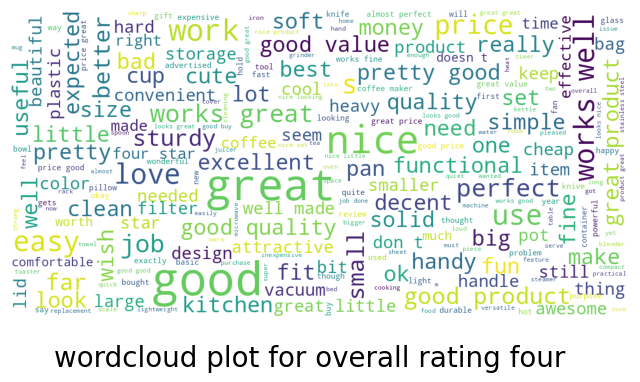

In [153]:
#plot the graph of four rating
wordcloud_plot(review_text_for_overall['clean_summary'][3],title='wordcloud plot for overall rating four')

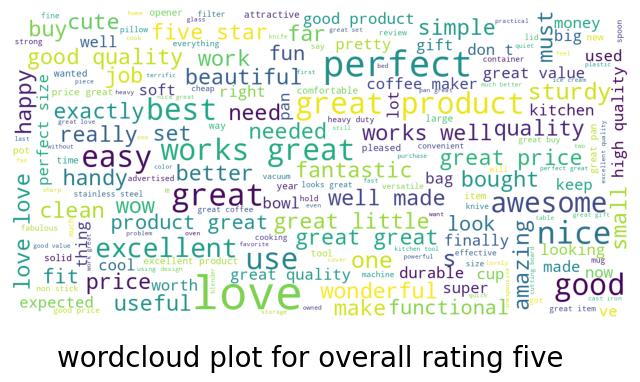

In [154]:
#plot the graph of five rating
wordcloud_plot(review_text_for_overall['clean_summary'][4],title='wordcloud plot for overall rating five')

#### Applying KNN model to find out five nearest prodcuts:

To find the 5 nearest neighbors, I am going to use NearestNeighbors algorithm.

In [155]:
#The code is used to calculate the nearest neighbors of a given point in a dataset.
#with n=5 and algorithm ball_tree and fit the model
nearest_neighbors=NearestNeighbors(n_neighbors=5,algorithm='ball_tree').fit(x_train)

In [156]:
#The code will find the index of the nearest neighbor to X_train.
dist,index=nearest_neighbors.kneighbors(x_train)

We have predicted the 5 products based on ratings by using KNN

In [157]:
#iterate over the for lop with range of 0, X_test.shape[0]
for i in range(0,x_test.shape[0]):
    #The code will return the list of all the neighbors of X_test[i]
     test_neighbors=nearest_neighbors.kneighbors([x_test[i]])
    #The code sets the current product to be a related product of the first product.
     related_product_indices=test_neighbors[i]
    #The first line of code does this with the following command: first_nearest_product = str(first_nearest_product).strip('[]') This returns a string representation of "str(first)".
    #first_nearest_product = [prod[0] for prod in related_product_indices]
     first_nearest_product = [prod[0] for prod in related_product_indices]
    #The second line uses int() to convert it into an integer value.
    #first_nearest_product = str(first_nearest_product).strip('[]')
     first_nearest_product = str(first_nearest_product).strip('[]')
    # The code attempts to return the first product in the related-_product_indices list that is closest to the given product.
    #first_nearest_product = int(first_nearest_product)
     first_nearest_product = int(first_nearest_product)

#similar as we done for first nearest product
    #second_nearest_product = [prod[1] for prod in related_product_indices]
     second_nearest_product = [prod[1] for prod in related_product_indices]
    #second_nearest_product = str(second_nearest_product).strip('[]')
     second_nearest_product = str(second_nearest_product).strip('[]')
    #second_nearest_product = int(second_nearest_product)
     second_nearest_product = int(second_nearest_product)

#similar for thirdth
     third_nearest_product = [prod[2] for prod in related_product_indices]
     third_nearest_product=str(third_nearest_product).strip("[]")
     third_nearest_product=int(third_nearest_product)


#similar for fourth
     four_nearest_product = [prod[3] for prod in related_product_indices]
     four_nearest_product=str(four_nearest_product).strip("[]")
     four_nearest_product=int(four_nearest_product)

#similar for fiveth
     five_nearest_product = [prod[4] for prod in related_product_indices]
     five_nearest_product=str(five_nearest_product).strip("[]")
     five_nearest_product=int(five_nearest_product)
#we will use try and except method
     try:

        #for getting reccommendation
         if i<4:

            #print for the product
            print('Based on product reviews of ', df_model_data['asin'][x_train.shape[0] + i], ' the average rating is ', df_model_data['overall'][X_train.shape[0] + i])

            #for 1st recommended product
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',df_model_data['overall'][first_nearest_product])

            #for 2nd recommend product kindly make the changes
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',df_model_data['overall'][first_nearest_product])
            #for 3rd recommend product kindly make the changes
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',df_model_data['overall'][first_nearest_product])
            #for 4nd recommend product kindly make the changes
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',df_model_data['overall'][first_nearest_product])
            #for 5th recommend product kindly make the changes
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',df_model_data['overall'][first_nearest_product])
            print('-------------------------------------------------------------------------------------------')
    #except
     except:
      #pass
        pass

ValueError: ignored

#Conclusion:

1. Building an item-based collaborative filtering system based on K - nearest neighbors to find the  most similar products. I used Amazon Home and Kitchen reviews dataset. Also, build K neighbors classifier model to predict overall review rating based on text reviews.

2. Analyzing the performance metrics of the above recommender system

##Summary

Within this e-commerce data science project.

1. we have come up with KNN product recommendater system for customers based on their purchase history and product reviews (Amazon's home and kitchen dataset)

2. we also performed sentiment analysis on any given product for a given customer (Amazon's home and kitchen dataset)

Great job!! You have come to the end of this assignment. Treat yourself for this :))


![](https://c.tenor.com/0rXHIkyr6bYAAAAM/well-done-very-well-done-sir.gif)



Please help us in improving by filling this  [Feedback form](https://forms.zohopublic.in/cloudyml/form/CloudyMLDeepLearningFeedbackForm/formperma/VCFbldnXAnbcgAIl0lWv2blgHdSldheO4RfktMdgK7s).
